In [21]:
import qutip as qt
import numpy as np


def regularized_logical_gkp(beta, mu, n_max, N):
    """
    Creates the regularized logical square GKP state.
    The implementation is based on the formula (24) of the paper
    by T. Matsuura et al., Equivalence of approximate Gottesman-Kitaev-Preskill
    codes [PRA 102 032408 (2020)].

    The parameters are transformed to represent the equivalent state that is
    obtained from the Fock damping regularization.

    Parameters
    ----------
    beta: float
        Regularization parameter
    mu: int
        used to choose either zero-logical or one-logical GKPS state.
    n_max: int
        Determines the maximum number of peaks to be considered.
        The number of peaks is given by :math:`2 n_{max} + 1`.

    N: int
        Fock space cut-off.

    Returns
    -------
    qutip ket-state
        Normalized GKP state.

    """
    kappa = np.sqrt(np.tanh(beta))
    Delta = np.sqrt(np.sinh(beta) * np.cosh(beta))
    a = qt.destroy(N)
    psi0 = qt.fock(N)

    def _S_r(r):
        """
        Private Function for squeezing operator

        Parameters
        ----------
        r: float,
            Squeezing parameter (real).

        Returns
        -------
        qutip operator

        """

        return (r / 2 * (a**2 - a.dag() ** 2)).expm()

    def _D_x(x):
        """
        Private function for the displacement operator

        Parameters
        ----------
        x: complex
            coherence parameters alpha.

        Returns
        -------
        qutip operator

        """
        return (x * a.dag() - np.conjugate(x) * a).expm()

    def _env(kappa, n, mu):
        """
        Private function the keeps track of the envelope

        Parameters
        ----------
        Delta: float,
            squeezing variance.
        n: int
        mu: int
            either 0 or 1 for each basis state.

        Returns
        -------
        float

        """
        return np.exp(-np.pi / 2 * kappa**2 * (2 * n + mu) ** 2)

    def _summand(Delta, n, mu):
        """
        Single term in GKPS state

        Parameters
        ----------
        Delta: float,
            squeezing variance.
        n: int,
        mu: int,
            either 0 or 1 for each basis state.
        """

        return (
            _env(kappa, n, mu)
            * _D_x(np.sqrt(np.pi / 2) * (2 * n + mu))
            * _S_r(-np.log(Delta))
        ) * psi0

    out = qt.Qobj()
    for n in range(-n_max, n_max):
        out += _summand(Delta, n, mu)

    return out.unit()


def hermite_functions(n_max, x):
    """
    Subrutine to calculate Hermite functions used for quadrature distribution

    Parameters
    ----------
    n_max : Integer
        Index of largest Hermite function.
    x : array
        x-axis.

    Returns
    -------
    Hlist : list
        List of Hermite functions.

    """
    Hlist = []
    Hlist.append(np.pi ** (-1 / 4) * np.exp(-1 / 2 * x**2))
    if n_max > 0:
        Hlist.append(np.sqrt(2) * x * np.pi ** (-1 / 4) * np.exp(-1 / 2 * x**2))
        for n in range(1, n_max):
            Hlist.append(
                (x * Hlist[n] - np.sqrt(n / 2) * Hlist[n - 1]) / np.sqrt((n + 1) / 2)
            )
    return Hlist


def quadrature_eigenstate(cutoff, x, angle=0):
    """
    Quadrature eigenstate |x>

    Parameters
    ----------
    cutoff : integer
        Fock space cutoff dimension.
    x : real number
        eigenvalue of the state.
    angle : real number or 'q' or 'p', optional
        quadrature direction. The default is 0.

    Returns
    -------
    qutip Qobj
        quadrature eigenstate in the Fock basis.

    """
    psi = np.zeros(cutoff)
    if angle == "p":
        angle = np.pi / 2
    if angle == "q":
        angle = 0
    Hlist = hermite_functions(cutoff - 1, x)
    psi = qt.Qobj(np.array(Hlist))
    R = (1j * angle * qt.num(cutoff)).expm()
    return R * qt.Qobj(psi)


In [59]:
beta = 0.05  # aedjusts the squeezing / peak width and overall envelope
mu = 1  # logical bit
n_max = 15  # number of peaks, if you don't push beta to too small values, you won't need to adjust this
N = 96  # Fock space cutoff, increase until convergence

state = regularized_logical_gkp(beta, mu, n_max, N)
x = np.linspace(-n_max //2, n_max // 2, 1024) * np.sqrt(np.pi * 2)
Ψ = [state.overlap(quadrature_eigenstate(N, x_i)) for x_i in x]



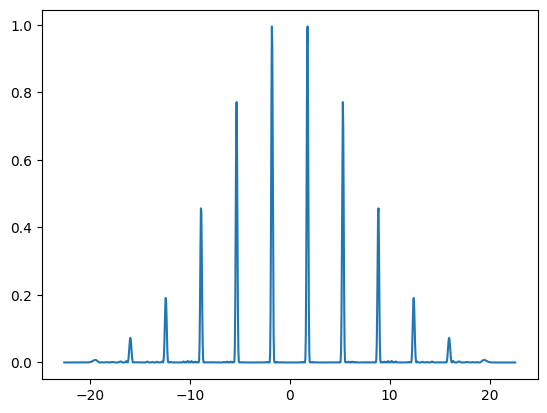

In [58]:
import matplotlib.pyplot as plt

plt.plot(x, np.abs(Ψ) ** 2)